In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.metrics import mean_squared_error

In [2]:
# imported all the csv files into the notebook. 
test1_df = pd.read_csv('SE_rents2018_test1.csv', index_col=0)
test2_df = pd.read_csv('SE_rents2018_test2.csv', index_col=0)
test3_df = pd.read_csv('SE_rents2018_test3.csv', index_col=0)
train_df = pd.read_csv('SE_rents2018_train.csv', index_col=0)


In [3]:
# imported the external dataset into the notebook. 
url = 'https://api.census.gov/data/2017/acs/acs5?'
params = {'get' : 'NAME,B19013_001E,B25058_001E',
          'for' : 'zip code tabulation area:*',}

r = requests.get(url, params=params)
print(r.url)

https://api.census.gov/data/2017/acs/acs5?get=NAME%2CB19013_001E%2CB25058_001E&for=zip+code+tabulation+area%3A%2A


In [4]:
#import median household income from census gov
income_df = pd.DataFrame(r.json()[1:], columns=r.json()[0])

In [5]:
income_df = (income_df
             .rename(
                 columns={
                          'B19013_001E' : 'Median Household Income',
                          'B25058_001E' : 'Median Rent',
                          'zip code tabulation area' : 'addr_zip',
                         }
             )
            )

In [6]:
# Converted the datatype to integer
income_df['addr_zip'] = income_df['addr_zip'].astype(int)
income_df['Median Rent'] = income_df['addr_zip'].astype(int)
income_df['Median Household Income'] = income_df['Median Household Income'].astype(int)

In [7]:
# This was the original dataset we wanted to use, but found that there was no correlation with rent whatsoever.
# However it maybe that this one particular dataset wasn't good enough.
# So we settled with the income data set. 

# Here is the link to the data set. https://catalog.data.gov/dataset/demographic-statistics-by-zip-code-acfc9
# demographic_by_zipcode_df = pd.read_csv('Demographic_Statistics_By_Zip_Code.csv', index_col=0)
# print(demographic_by_zipcode_df.columns)
# test_merge_df = pd.merge(test_merge_df,demographic_by_zipcode_df, left_on = test_merge_df.addr_zip , right_index=True, how = 'left')


In [8]:
#imported heatmap to see correlation
def get_heatmap(df):
    """Displays a heatmap with pearson's correlation"""
    corrmat = df.corr()
    top_corr = corrmat.index
    plt.figure(figsize=(len(df.columns),len(df.columns)))
    df_g = sns.heatmap(df[top_corr].corr(), annot=True, cmap="RdYlGn")
    return df_g

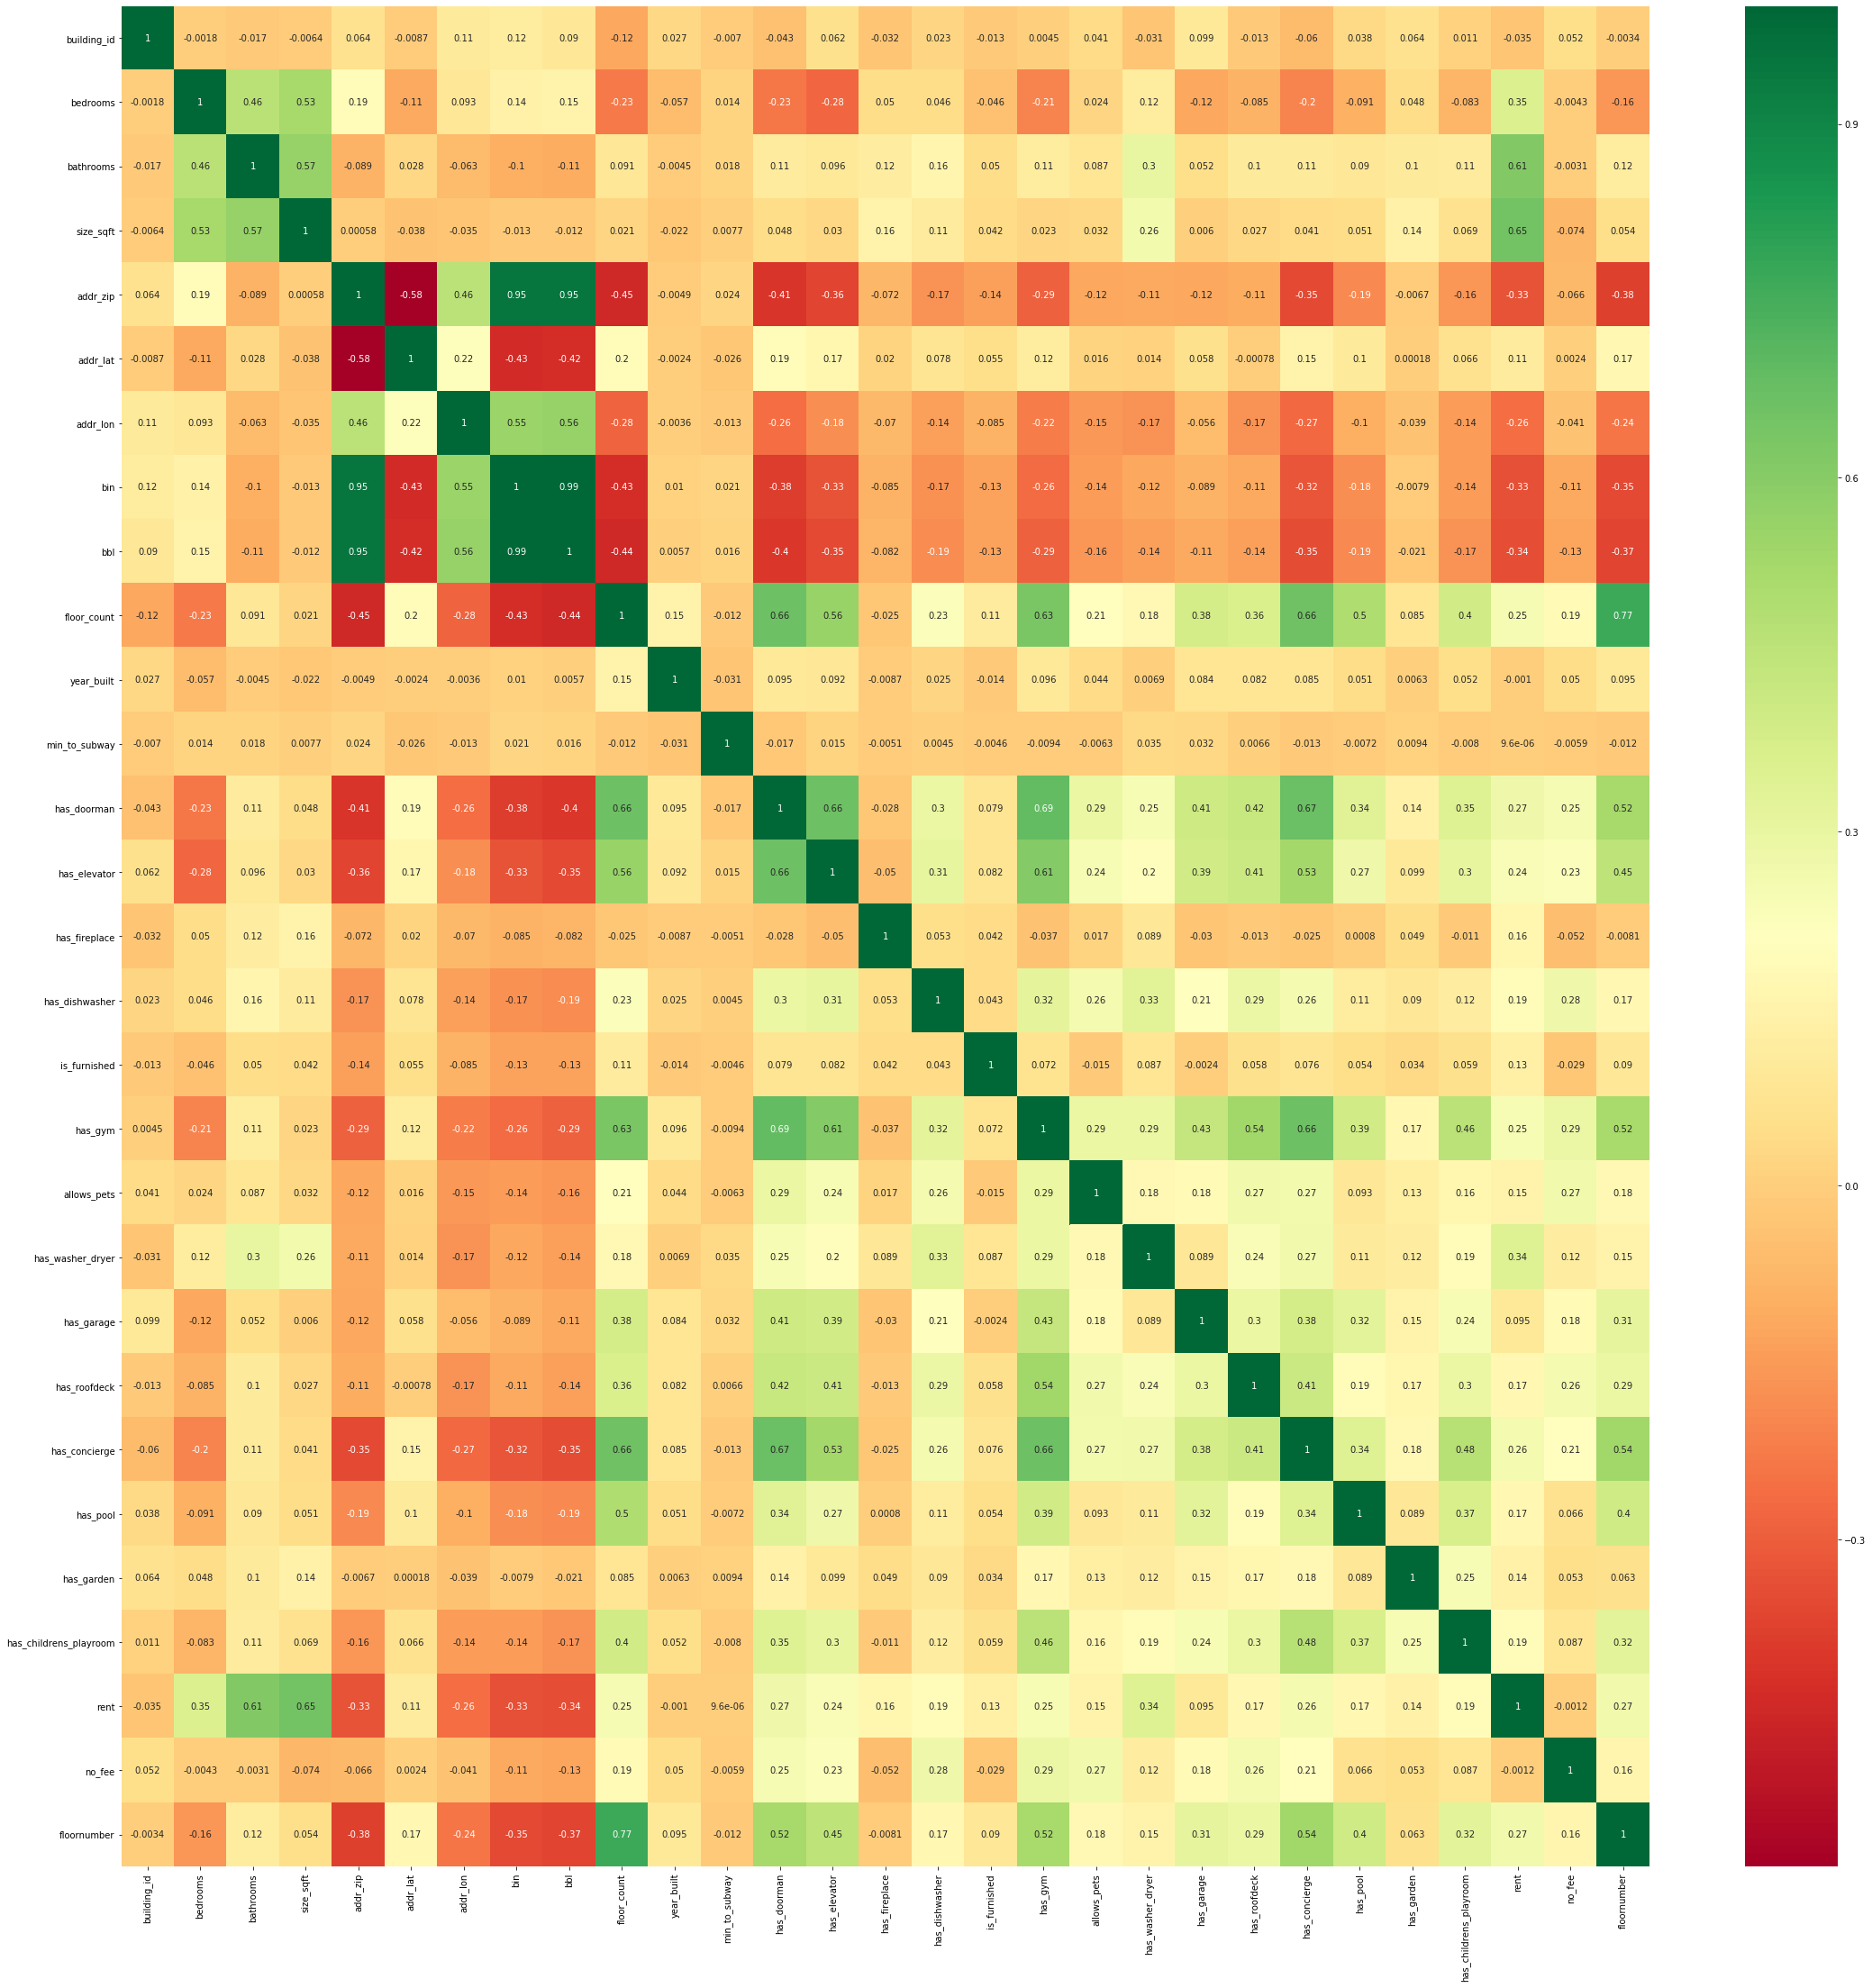

In [9]:
# Heatmap of all pair-wise features.
get_heatmap(train_df)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


def train_linear_reg_model(X_train, y_train, X_test, y_test):
    """Trains and test linear regression model and returns mean_squared_error of
    y_test and y_predicted. 
    ----------
    X_train : data frame, shape = [n_samples, n_features]
        n_samples the number of samples
        n_features the number of features for each sample.
        
    y_train : data frame, shape = [n_samples]
        n_sample target values.
        
    X_test : data frame, shape = [n_samples, n_features]
        n_samples the number of samples
        n_features the number of features for each sample.
        
    y_test : data frame, shape = [n_samples]
        n_sample target values.
        
    Return 
        (data frame) y_prediction: predictions made from X_test
        (float) mean_squared_error of (y_test and y_prediction)
        (LinearRegression) returns the linear regression model.
    """

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_prediction = lr.predict(X_test)
    
    return lr ,y_prediction, mean_squared_error(y_test, y_prediction)

In [11]:
# Merged the external data with training data and all test dataframes. 
train_merge_df = train_df.merge(right=income_df,how='left', on='addr_zip')
test1_merge_df = test1_df.merge(right=income_df,how='left', on='addr_zip')
test2_merge_df = test2_df.merge(right=income_df,how='left', on='addr_zip')
test3_merge_df = test3_df.merge(right=income_df,how='left', on='addr_zip')

# Martin's null value fill.

relfeatures_df = train_merge_df[['size_sqft', 'bathrooms', 'bedrooms', 'has_gym', 'bin', 'addr_zip', 'bbl', 'rent']].copy()

#missing value percentages 
mv_percentages = train_merge_df.isna().sum()/len(train_merge_df)*100
mv_percentages

#  removes all rows of the dataframe where there is a missing value in a column with less than 5% of its values missing
for name, percent in mv_percentages.iteritems():
    if(percent<5 and percent > 0):
        train_merge_df = train_merge_df[pd.notnull(train_merge_df[name])]
train_merge_df.shape

#if missing values is greater than 5 percent we cant afford to lose so much data so, for numeric data we will fill it in with the median
#for any other data type we will fill it in with the mode (we can change the code from idmax to pandas mode if want)
from pandas.api.types import is_numeric_dtype
mv_percentages_step2 = train_merge_df.isna().sum()/len(train_merge_df)*100
for name, percent in mv_percentages_step2.iteritems():
    if(percent>=5):
        print(name + ": " + str(train_merge_df[name].value_counts().idxmax()))
        if(is_numeric_dtype(train_merge_df[name])):
            train_merge_df[name].fillna(train_merge_df[name].median(), inplace=True)
        else:
            train_merge_df[name].fillna(train_merge_df[name].value_counts().idxmax(), inplace=True)
            
            
# CLEAN THE DATA HERE CLEAN TRAIN_MERGE_DF
# due to time constraints we didn't remove the outliers. 

floornumber: 2.0
line: A


Text(0.5, 0, 'bbl')

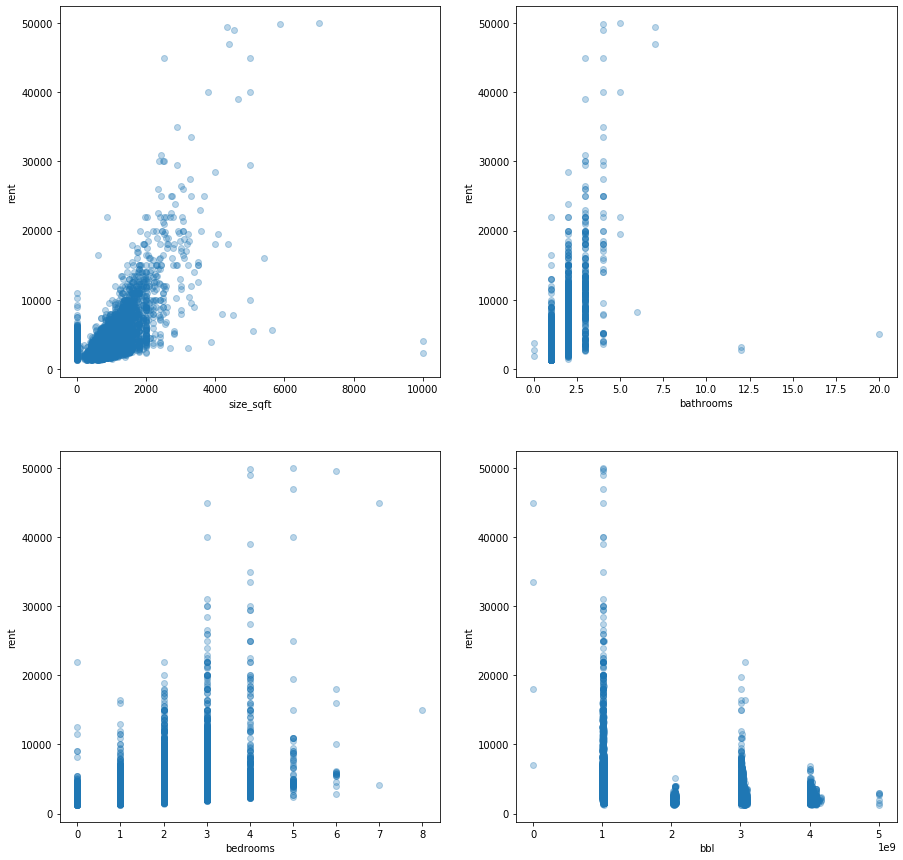

In [12]:
# Trying to get rid of outliers (graphing) Can get rid off but just for testing forex: 20 bathrooms for that price?
relfeatures_df = train_merge_df[['size_sqft', 'bathrooms', 'bedrooms', 'has_gym', 'bin', 'addr_zip', 'bbl', 'rent']].copy()


fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(relfeatures_df["size_sqft"], relfeatures_df["rent"], alpha=0.3)
ax1.set_ylabel("rent")
ax1.set_xlabel("size_sqft")


ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(relfeatures_df["bathrooms"], relfeatures_df["rent"], alpha=0.3)
ax2.set_ylabel("rent")
ax2.set_xlabel("bathrooms")

ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(relfeatures_df["bedrooms"], relfeatures_df["rent"], alpha=0.3)
ax3.set_ylabel("rent")
ax3.set_xlabel("bedrooms")

ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(relfeatures_df["bbl"], relfeatures_df["rent"], alpha=0.3)
ax4.set_ylabel("rent")
ax4.set_xlabel("bbl")

In [13]:
# Here is what the new training set looks like.
train_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11223 entries, 0 to 11999
Data columns (total 41 columns):
addr_unit                  11223 non-null object
building_id                11223 non-null int64
bedrooms                   11223 non-null int64
bathrooms                  11223 non-null float64
size_sqft                  11223 non-null float64
created_at                 11223 non-null object
addr_street                11223 non-null object
addr_city                  11223 non-null object
addr_zip                   11223 non-null int64
addr_lat                   11223 non-null float64
addr_lon                   11223 non-null float64
bin                        11223 non-null float64
bbl                        11223 non-null int64
floor_count                11223 non-null float64
year_built                 11223 non-null float64
min_to_subway              11223 non-null float64
has_doorman                11223 non-null int64
has_elevator               11223 non-null int64
has_fir

In [14]:
# columns we need
columns_needed = ['bedrooms','bathrooms', 'size_sqft','bbl','floor_count','Median Household Income','rent']
# Feature columns
features = ['bedrooms','bathrooms', 'size_sqft','bbl','floor_count','Median Household Income']

# Extract columns needed.
train_merge_df = train_merge_df[columns_needed]

# Getting the target column for training.
train_merge_target = train_merge_df[['rent']]
# Getting the features for training.
train_merge_df = train_merge_df[features]

# Getting the target columns to get accuracy of predictions of test1
test1_merge_target = test1_merge_df[['rent']]
# Extracting the columns needed for testing. Useing test1.csv file.
test1_merge_df = test1_merge_df[features]

# filled test1 missing data with median of the column.
test1_merge_df = test1_merge_df.fillna(test1_merge_df.median())

# Train the linear regression model and test test1.csv.
lr, y_prediction, mse = train_linear_reg_model(train_merge_df, train_merge_target, test1_merge_df, test1_merge_target)
print("Mean square error of test1: " + str(mse))

Mean square error of test1: 3309987.578814787


In [15]:
# Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

poly = PolynomialFeatures()
poly = poly.fit_transform(train_merge_df)
model = Pipeline([('poly', PolynomialFeatures(degree=3)), 
                  ('linear', LinearRegression(normalize=True))])

model = model.fit(train_merge_df, train_merge_target)
test1_predict = model.predict(test1_merge_df)
train_predict = model.predict(train_merge_df)
print("Mean squared error: " + str(mean_squared_error(test1_merge_target, test1_predict)))

print("Test R2 value is: " + str(r2_score(test1_merge_target, test1_predict)))
# Train R2 is to check if the model overfits the training data.
print("Train R2 value is: " + str(r2_score(train_merge_target, train_predict)))

Mean squared error: 2568977.7842203164
Test R2 value is: 0.6555020708582924
Train R2 value is: 0.8374397292459014


In [16]:
# Decision trees
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor(criterion='friedman_mse')
regr.fit(train_merge_df, train_merge_target)
test1_regr_predict = regr.predict(test1_merge_df)
print("MSE is " + str(mean_squared_error(test1_merge_target, test1_regr_predict)))
print("Test R2 value is: " + str(r2_score(test1_merge_target, test1_regr_predict)))
train_regr_predict = regr.predict(train_merge_df)

# Train R2 is to check if the model overfits the training data.
print("Train R2 value is: " + str(r2_score(train_merge_target, train_regr_predict)))

MSE is 3123598.2765883645
Test R2 value is: 0.5811278928276578
Train R2 value is: 0.997310540602104


In [17]:
# Our final model. We reinstantiate the datasets so that the model hasn't 
# been changed in someway previously. 
train_merge_df = train_df.merge(right=income_df,how='left', on='addr_zip')
train_merge_df.index = train_df.index
test1_merge_df = test1_df.merge(right=income_df,how='left', on='addr_zip')
test1_merge_df.index = test1_df.index
test2_merge_df = test2_df.merge(right=income_df,how='left', on='addr_zip')
test2_merge_df.index = test2_df.index
test3_merge_df = test3_df.merge(right=income_df,how='left', on='addr_zip')
test3_merge_df.index = test3_df.index

# fill nulls and NaNs with median
train_merge_df = train_merge_df.fillna(train_merge_df.median())
test1_merge_df = test1_merge_df.fillna(test1_merge_df.median())
test3_merge_df = test3_merge_df.fillna(test3_merge_df.median())

In [18]:
from sklearn.ensemble import RandomForestRegressor

features = ['bathrooms', 'size_sqft','bin','bbl','has_doorman','floor_count','has_gym', 'rent', 'Median Household Income']
features_df = train_merge_df[features];

#hot encode classification variables
features_df = pd.get_dummies(features_df)

# the feature we are trying to predict
labels = np.array(features_df['rent'])
features_df = features_df.drop('rent', axis=1)

# convertint to list
feature_list = list(features_df.columns)
features_df = np.array(features_df)

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(features_df, train_merge_df.rent);
columns_needed = ['bathrooms', 'size_sqft','bin','bbl','has_doorman','floor_count','has_gym', 'Median Household Income']

df = test1_merge_df[columns_needed].values
y_val = test1_merge_df['rent']
predictions = rf.predict(df)

# Mean squared error of random forest regressor. This gave us the lowest mse for test1.csv
mean_squared_error(y_val, predictions)

1797974.4239098649

In [19]:
# Predicting test3 rent using the random forest regressor. 
test_dataset = test3_merge_df[columns_needed].values
test3_predictions = rf.predict(test_dataset)

In [20]:
# Creates the test3_rent_predictions.csv 
num = np.max(test3_predictions)
test3_rent_predictions = pd.DataFrame(test3_predictions, index=test3_merge_df.index, columns=['rent'])
test3_rent_predictions.to_csv('test3_rent_predictions.csv')

In [21]:
display(test3_rent_predictions.info())
display(test3_rent_predictions.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 7455565 to 7450378
Data columns (total 1 columns):
rent    2000 non-null float64
dtypes: float64(1)
memory usage: 31.2 KB


None

,rent
rental_id,
7455565,3889.054119
7473295,2269.653500
7459804,3162.779333
7456330,2239.002786
7443595,3723.638024
7502623,4010.889457
7459171,3601.688607
7447600,1764.048500
7505254,3039.987708


In [22]:
y_mse = []
for i in range(1, 10):
    features = ['bathrooms', 'size_sqft','bin','bbl','has_doorman','floor_count','has_gym', 'rent', 'Median Household Income']
    features_df = train_merge_df[features];

    #hot encode classification variables
    features_df = pd.get_dummies(features_df)

    # the feature we are trying to predict
    labels = np.array(features_df['rent'])
    features_df = features_df.drop('rent', axis=1)

    # convertint to list
    feature_list = list(features_df.columns)
    features_df = np.array(features_df)

    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(max_depth=i, n_estimators = 1000, random_state = 42)

    # Train the model on training data
    rf.fit(features_df, train_merge_df.rent);
    columns_needed = ['bathrooms', 'size_sqft','bin','bbl','has_doorman','floor_count','has_gym', 'Median Household Income']

    df = test1_merge_df[columns_needed].values
    y_val = test1_merge_df['rent']
    predictions = rf.predict(df)

    # Mean squared error of random forest regressor. This gave us the lowest mse for test1.csv
    mse = mean_squared_error(y_val, predictions)
    y_mse.append(mse)

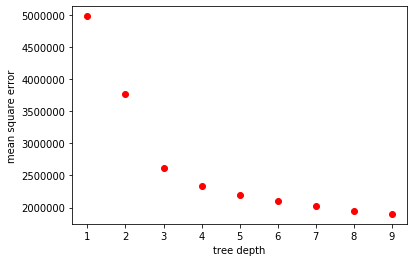

In [23]:
import matplotlib.pyplot as plt

x_tree_dept = [x for x in range(1,10)]
plt.plot(x_tree_dept, y_mse, 'ro')
plt.xlabel('tree depth')
plt.ylabel('mean square error')
plt.show()